Starting Portfolio Value: 100000.00
2010-10-18, BUY ORDER SENT, Price: 1184.71, S-EMA: 1130.89., L-EMA: 1120.76, Size: 80.00
2010-10-19, BUY EXECUTED, Price: 1178.64, Size: 80, Cost: 94291.20, Comm 94.29, RemSize: 0, RemCash: 5614.51
2011-08-16, SELL ORDER SENT,Price: 1192.76, S-EMA: 1268.47., L-EMA: 1268.86, Size: 80.00
2011-08-17, SELL EXECUTED, Price: 1192.89, Size: -80, Cost: 94291.20, Comm 95.43, RemSize: 0, RemCash: 100950.28
2011-08-17, OPERATION PROFIT, GROSS 1140.00, NET 950.28
2011-08-17, SELL ORDER SENT, Price: 1193.89, S-EMA: 1265.54., L-EMA: 1268.11, Size: 80.00
2011-08-18, SELL EXECUTED, Price: 1189.62, Size: -80, Cost: -95169.60, Comm 95.17, RemSize: 0, RemCash: 196024.71
2012-01-05, BUY ORDER SENT, Price: 1281.06, S-EMA: 1237.39., L-EMA: 1237.31, Size: -80.00
2012-01-06, BUY EXECUTED, Price: 1280.93, Size: 80, Cost: -95169.60, Comm 102.47, RemSize: 0, RemCash: 93447.83
2012-01-06, OPERATION PROFIT, GROSS -7304.80, NET -7502.44
2012-01-06, BUY ORDER SENT, Price: 1277.81,

2018  0.017  0.025  
-------------- ANNUAL RETURN ----------------
return  2010    0.062
        2011   -0.102
        2012    0.086
        2013    0.281
        2014    0.109
        2015   -0.139
        2016   -0.068
        2017    0.184
        2018    0.056
dtype: float64


Start date,2010-01-04
End date,2018-12-28
Total months,107
,Backtest
Annual return,4.4%
Cumulative returns,47.7%
Annual volatility,13.1%
Sharpe ratio,0.40
Calmar ratio,0.15
Stability,0.55
Max drawdown,-30.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.23,2015-05-21,2016-06-27,2018-09-20,871
1,18.73,2011-04-29,2011-10-28,2013-04-10,509
2,9.76,2018-09-20,2018-11-23,2018-12-24,68
3,7.13,2014-09-18,2014-10-15,2014-10-31,32
4,6.09,2011-02-18,2011-03-16,2011-04-26,48


d:\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.06%,-6.30%,4.46%
Fukushima,0.12%,-1.85%,1.42%
EZB IR Event,-0.01%,-1.00%,1.55%
Flash Crash,0.00%,0.00%,0.00%
Apr14,0.03%,-2.01%,1.05%
Oct14,0.10%,-1.99%,1.88%
Fall2015,-0.21%,-3.80%,3.75%
Recovery,0.01%,-6.30%,4.46%
New Normal,0.03%,-3.92%,3.75%


d:\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Top 10 long positions of all time,max
SPX,96.59%


Top 10 short positions of all time,max
SPX,-111.11%


Top 10 positions of all time,max
SPX,111.11%


d:\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
d:\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


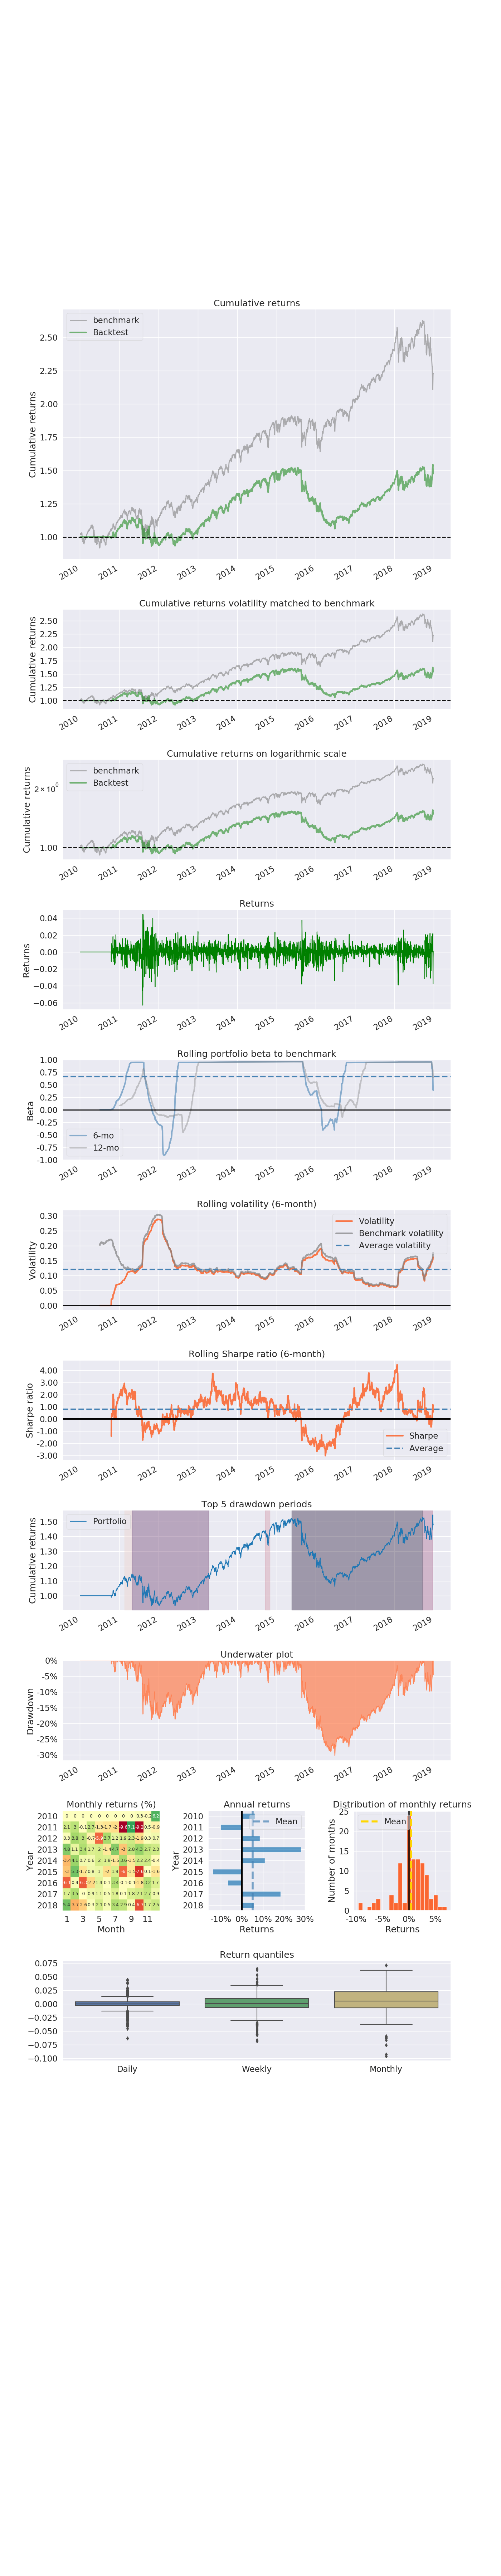

<IPython.core.display.Javascript object>


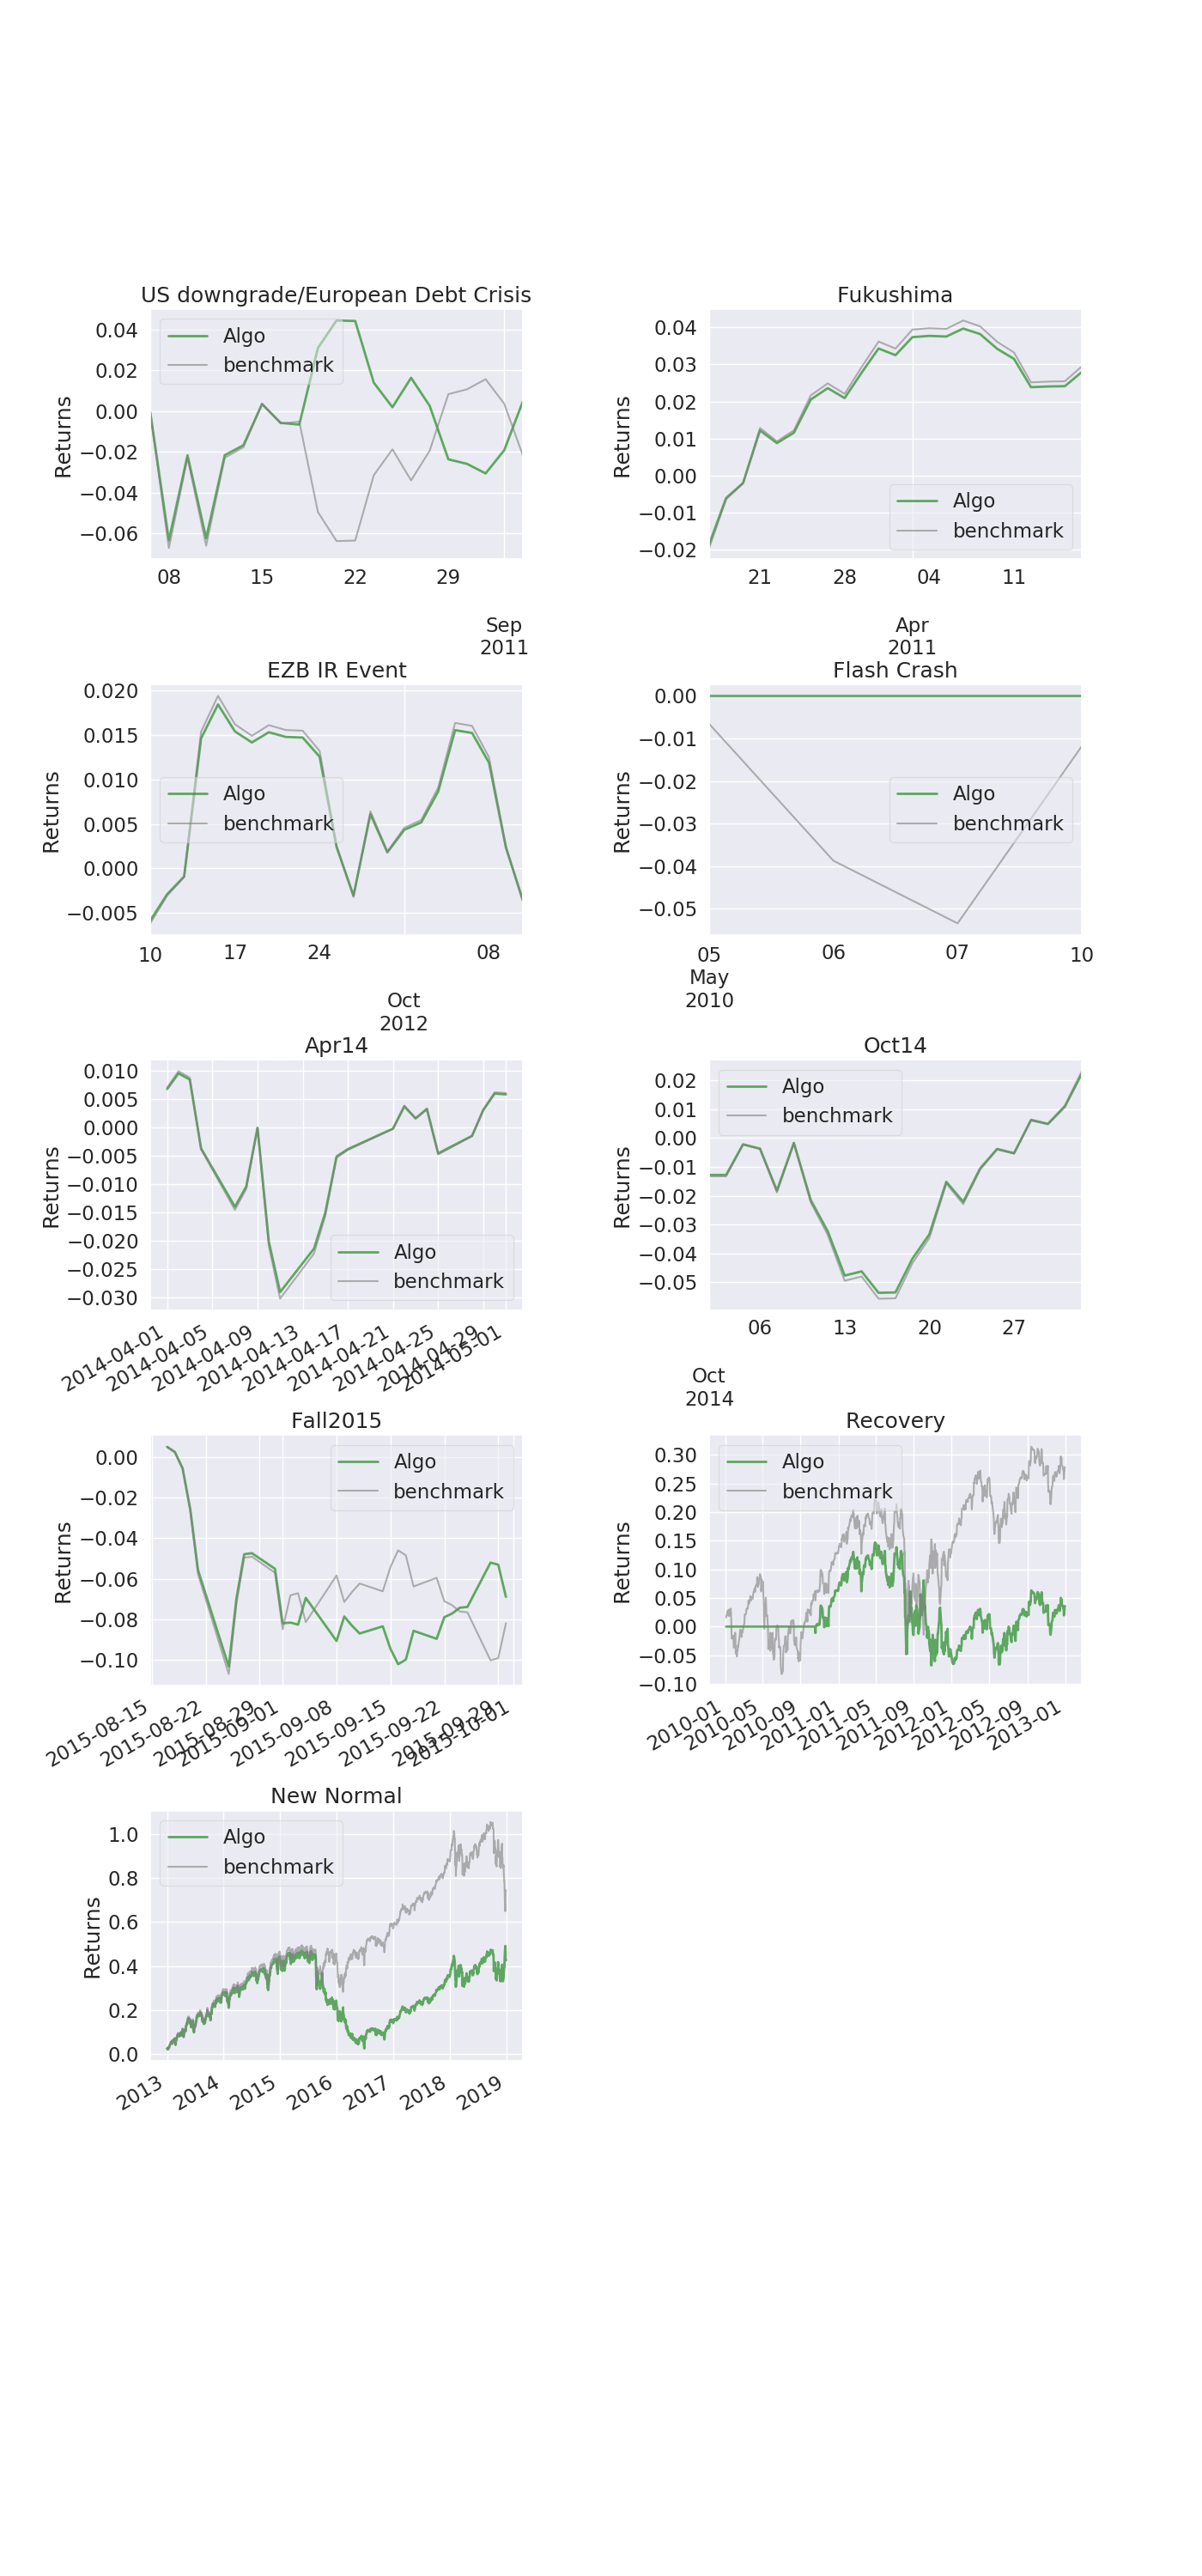

<IPython.core.display.Javascript object>


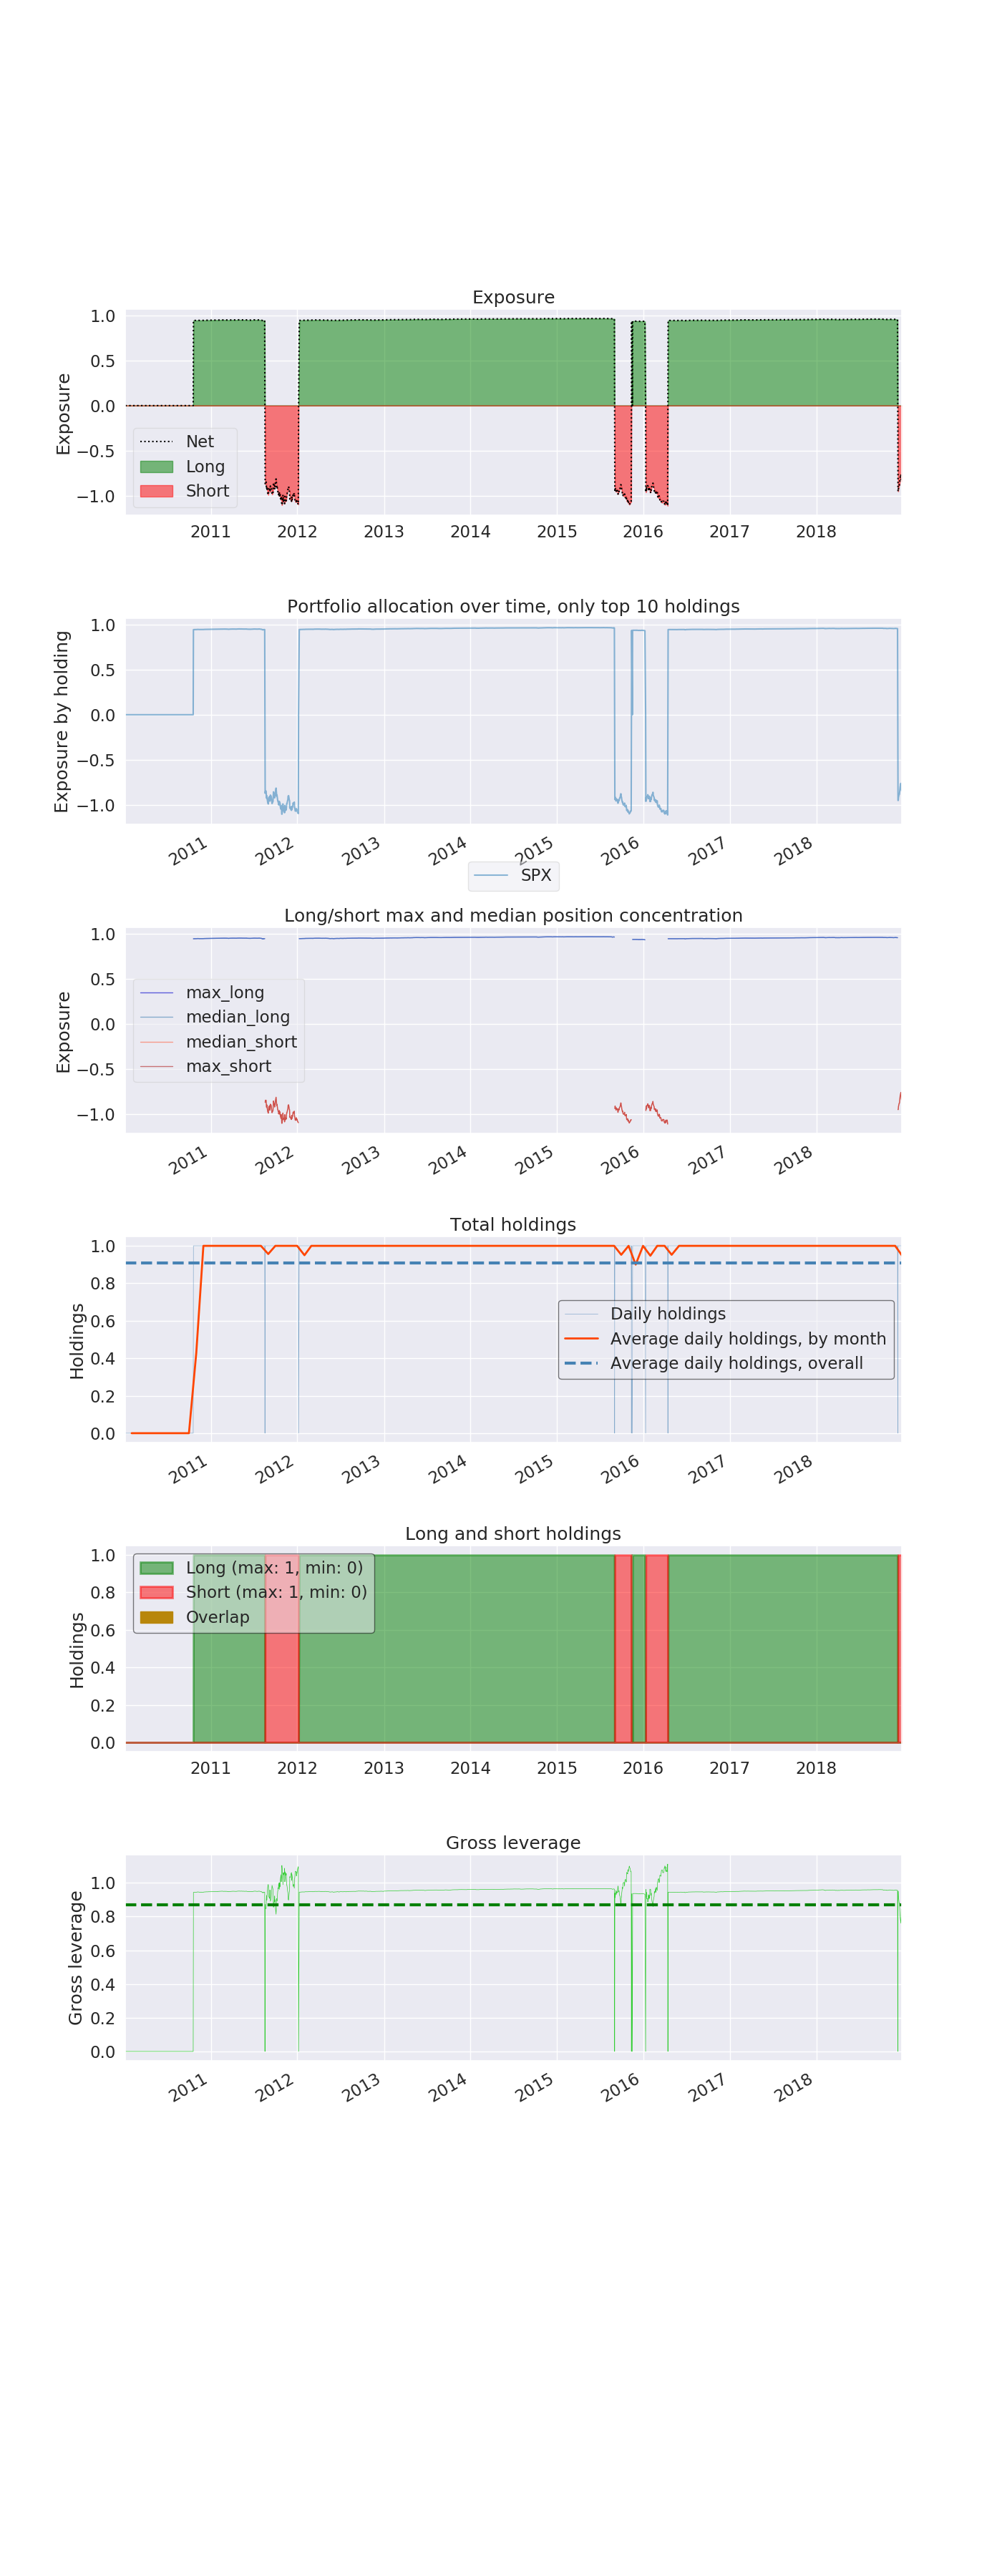

<IPython.core.display.Javascript object>


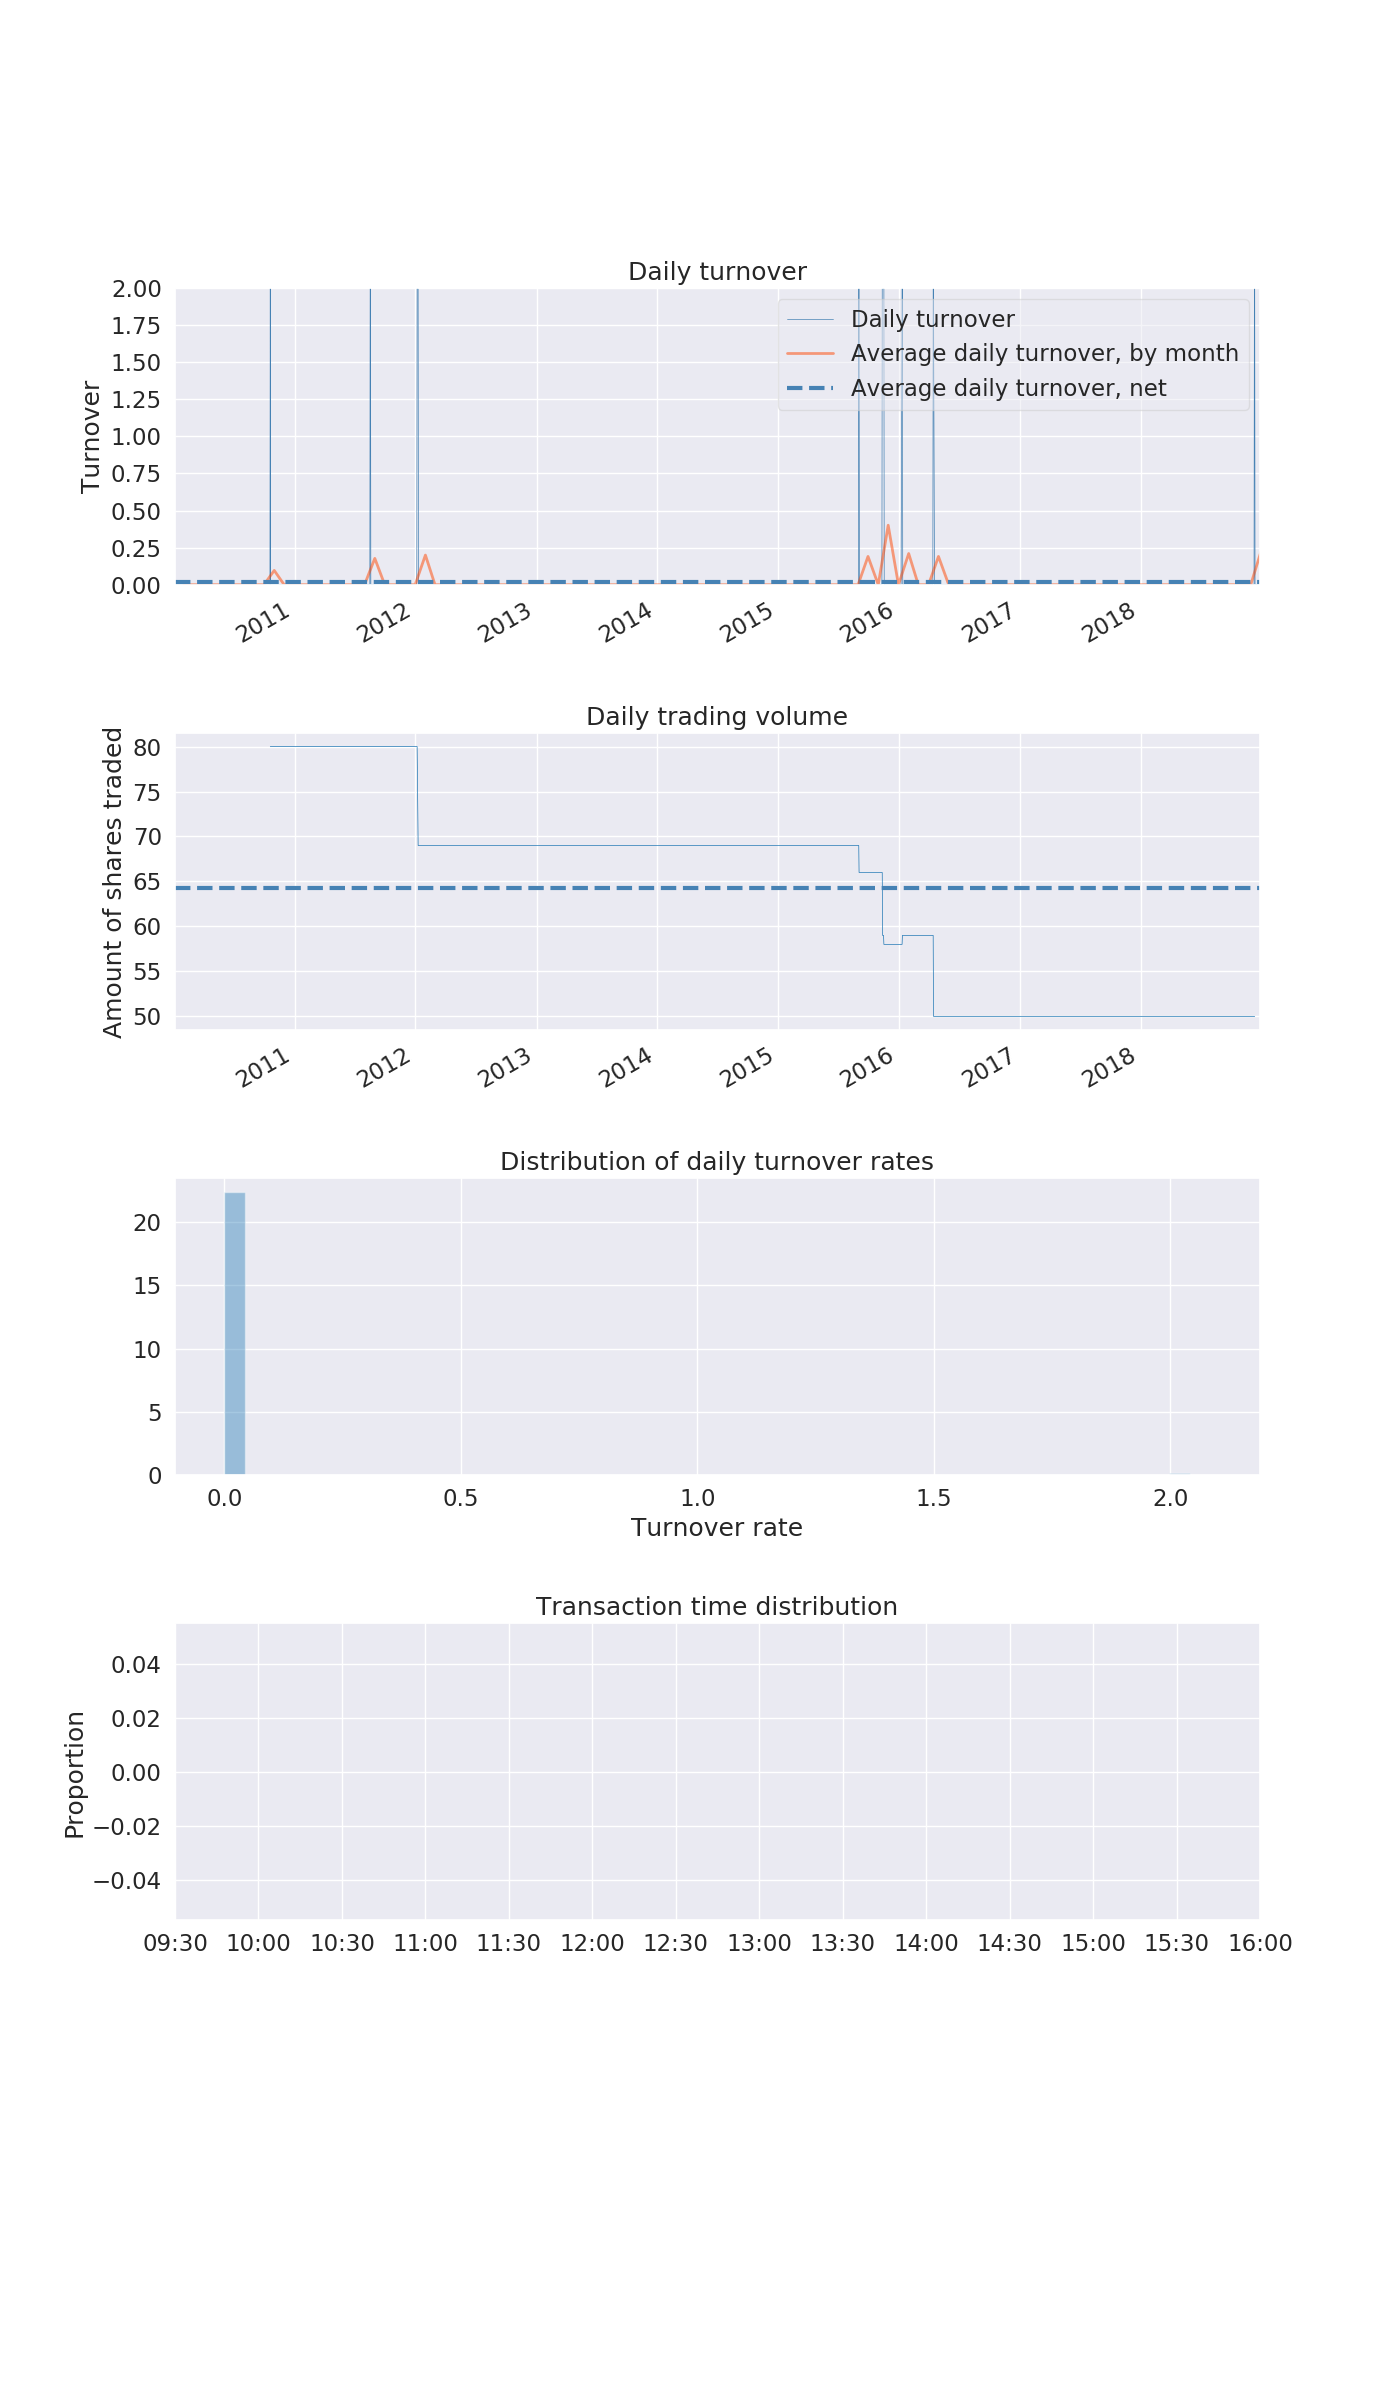

In [93]:
'''
Classical MovingAverageCrossStrategy, golden cross buy; dead cross sell
Close position when opposite cross happens
Negative return and sharp ratio.
'''
import os
import pandas as pd
from datetime import datetime
import backtrader as bt
# set browser full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

class MADoubleCross(bt.Strategy):
    params = (
        ('short_window', 20),
        ('long_window', 20),
        ('printlog', False),        # comma is required
    )

    def __init__(self):
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.bar_executed = None
        self.val_start = None
        self.dataclose = self.datas[0].close
        self.short_ema = bt.indicators.ExponentialMovingAverage(self.dataclose, period = self.params.short_window)
        self.long_ema = bt.indicators.ExponentialMovingAverage(self.dataclose, period = self.params.long_window)

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:                # order.Partial
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Size: %.0f, Cost: %.2f, Comm %.2f, RemSize: %.0f, RemCash: %.2f' %
                    (order.executed.price,
                     order.executed.size,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.remsize,
                     self.broker.get_cash()))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Size: %.0f, Cost: %.2f, Comm %.2f, RemSize: %.0f, RemCash: %.2f' %
                         (order.executed.price,
                          order.executed.size,
                          order.executed.value,
                          order.executed.comm,
                          order.executed.remsize,
                          self.broker.get_cash()))

            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Expired, order.Margin, order.Rejected]:
            self.log('Order Failed')

        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.data.close[0])
        if self.order:
            return

        # open position
        if self.position.size == 0:
            if self.short_ema[0] > self.long_ema[0]:
                self.order = self.buy()
                self.log('BUY ORDER SENT, Price: %.2f, S-EMA: %.2f., L-EMA: %.2f, Size: %.2f' %
                         (self.dataclose[0],
                          self.short_ema[0],
                          self.long_ema[0],
                          self.getsizing(isbuy=True)))
            else:
                self.order = self.sell()
                self.log('SELL ORDER SENT, Price: %.2f, S-EMA: %.2f., L-EMA: %.2f, Size: %.2f' %
                         (self.dataclose[0],
                          self.short_ema[0],
                          self.long_ema[0],
                          self.getsizing(isbuy=True)))
        # close position; and open the other side
        else:
            if self.short_ema[0] > self.long_ema[0] and self.position.size < 0:
                self.order = self.buy()
                self.log('BUY ORDER SENT, Price: %.2f, S-EMA: %.2f., L-EMA: %.2f, Size: %.2f' %
                         (self.dataclose[0],
                          self.short_ema[0],
                          self.long_ema[0],
                          self.getsizing(isbuy=True)))
            elif self.short_ema[0] < self.long_ema[0] and self.position.size > 0:
                self.order = self.sell()
                self.log('SELL ORDER SENT,Price: %.2f, S-EMA: %.2f., L-EMA: %.2f, Size: %.2f' %
                         (self.dataclose[0],
                          self.short_ema[0],
                          self.long_ema[0],
                          self.getsizing(isbuy=True)))

    def stop(self):
        # calculate the actual returns
        print(self.analyzers)
        roi = (self.broker.get_value() / self.val_start) - 1.0
        self.log('ROI:        {:.2f}%'.format(100.0 * roi))
        self.log('(MA Period (%2d, %2d)) Ending Value %.2f' %
                 (self.params.short_window, self.params.long_window, self.broker.getvalue()), doprint=True)


if __name__ == '__main__':
    param_opt = False
    perf_eval = True
    benchmark = 'SPX'

    cerebro = bt.Cerebro()

    datapath = os.path.join('../data/', 'SPX.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        fromdate=datetime(2010, 1, 1),
        todate=datetime(2018, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    # cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    # PercentSizer will flat position first; overwrite if not desired.
    cerebro.addsizer(bt.sizers.PercentSizerInt, percents=95)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Add a strategy
    if param_opt:
        # Optimization
        cerebro.optstrategy(MADoubleCross, short_window=[10, 20], long_window=[50, 100, 200])
        perf_eval = False
    else:
        cerebro.addstrategy(MADoubleCross, short_window=50, long_window=200, printlog=True)

    # Add Analyzer
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    # Run over everything
    results = cerebro.run()

    # Print out the final result
    strat = results[0]
    print('Final Portfolio Value: %.2f, Sharpe Ratio: %.2f, DrawDown: %.2f, MoneyDown %.2f' %
          (cerebro.broker.getvalue(),
           strat.analyzers.SharpeRatio.get_analysis()['sharperatio'],
           strat.analyzers.DrawDown.get_analysis()['drawdown'],
           strat.analyzers.DrawDown.get_analysis()['moneydown']))

    if perf_eval:
        import matplotlib.pyplot as plt
        cerebro.plot(style='candlestick')
        plt.show()

        pyfoliozer = strat.analyzers.getbyname('pyfolio')
        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        print('-------------- RETURNS ----------------')
        print(returns)
        print('-------------- POSITIONS ----------------')
        print(positions)
        print('-------------- TRANSACTIONS ----------------')
        print(transactions)
        print('-------------- GROSS LEVERAGE ----------------')
        print(gross_lev)

        import empyrical as ep
        import pyfolio as pf

        bm_ret = None
        if benchmark:
            datapath = os.path.join('../data/', f'{benchmark}.csv')
            bm = pd.read_csv(datapath, index_col=0)
            bm_ret = bm['Adj Close'].pct_change().dropna()
            bm_ret.index = pd.to_datetime(bm_ret.index)
            # remove tzinfo
            returns.index = returns.index.tz_localize(None)
            bm_ret = bm_ret[returns.index]
            bm_ret.name = 'benchmark'

        perf_stats_strat = pf.timeseries.perf_stats(returns)
        perf_stats_all = perf_stats_strat
        if benchmark:
            perf_stats_bm = pf.timeseries.perf_stats(bm_ret)
            perf_stats_all = pd.concat([perf_stats_strat, perf_stats_bm], axis=1)
            perf_stats_all.columns = ['Strategy', 'Benchmark']

        drawdown_table = pf.timeseries.gen_drawdown_table(returns, 5)
        monthly_ret_table = ep.aggregate_returns(returns, 'monthly')
        monthly_ret_table = monthly_ret_table.unstack().round(3)
        ann_ret_df = pd.DataFrame(ep.aggregate_returns(returns, 'yearly'))
        ann_ret_df = ann_ret_df.unstack().round(3)
        print('-------------- PERFORMANCE ----------------')
        print(perf_stats_all)
        print('-------------- DRAWDOWN ----------------')
        print(drawdown_table)
        print('-------------- MONTHLY RETURN ----------------')
        print(monthly_ret_table)
        print('-------------- ANNUAL RETURN ----------------')
        print(ann_ret_df)

        pf.create_full_tear_sheet(
            returns,
            benchmark_rets=bm_ret if benchmark else None,
            positions=positions,
            transactions=transactions,
            #live_start_date='2005-05-01',
            round_trips=False)
        plt.show()